In [1]:
using DifferentialEquations
using OrdinaryDiffEq
using DiffEqBase
using Sundials
using ODEInterfaceDiffEq
using Plots
using Measures
using CSV
using DataFrames
using EasyFit
using StatsPlots
using LinearAlgebra
using Random
using Distributions
using OrdinaryDiffEq
Random.seed!(145975);
using KernelDensity
using LaTeXStrings
using StatsBase
using JLD2
using HypothesisTests



In [2]:
trueP = [48.0, 55.0,0.005911,0.01832,0.042171,0.5365,0.98047,0.991257,0.93335,0.008241,0.9943848,0.001974,   15];

bounds = [[48, 55, 0.001, 0.005, 0.01, 0.1, 0.7, 0.7, 0.7, 0.005, 0.7, 0.0008, 15],
          [48, 55, 0.01, 0.05, 0.08, 0.8, 1.2, 1.2, 1.2, 0.012, 1.2, 0.005, 15]];

InitsY0 = [450, 12599, 226];

boundY0 = [[300, 7000, 100],
           [1000, 25000, 1000]];

# Plot Posteriors

In [50]:
posterR = Matrix(CSV.read("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ComputationalBayesianOED\\Results\\PosteriorCompetitiveRepression_Rand1_Try2.csv", DataFrame));
posterO = Matrix(CSV.read("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ComputationalBayesianOED\\Results\\PosteriorCompetitiveRepression_OED2_Try2.csv", DataFrame));
posterOM = Matrix(CSV.read("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ComputationalBayesianOED\\Results\\TestOEDMulti2.csv", DataFrame));

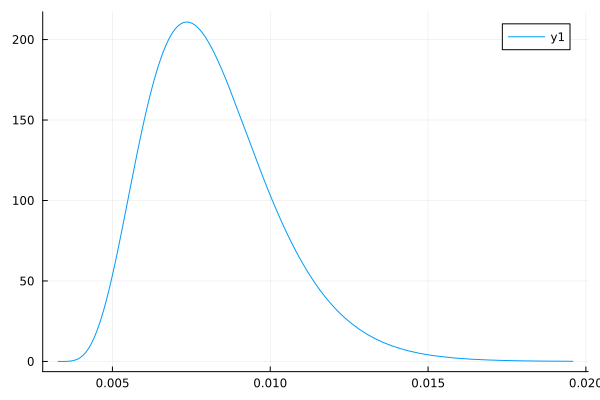

In [26]:
plot(0.00328704+ ((Gamma(5.807499992288657, 0.12918917739166189) - (0.001))*(0.0164066 - 0.00328704))/(2 - (0.001)))


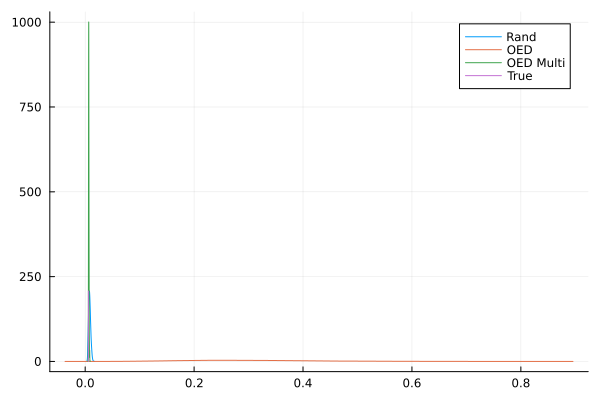

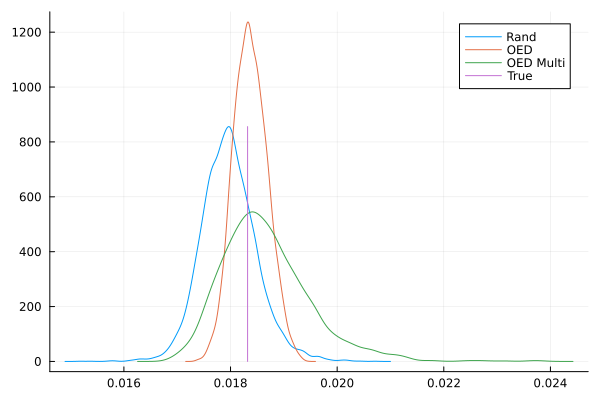

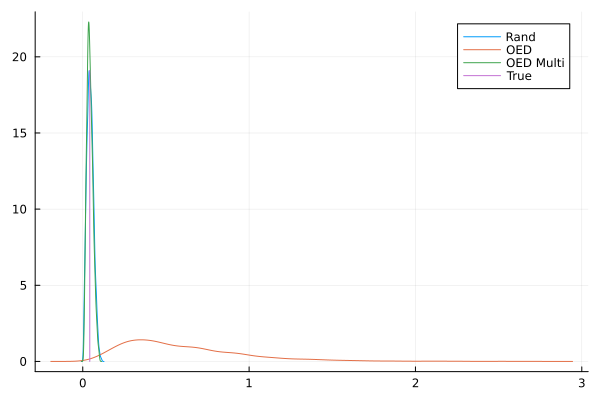

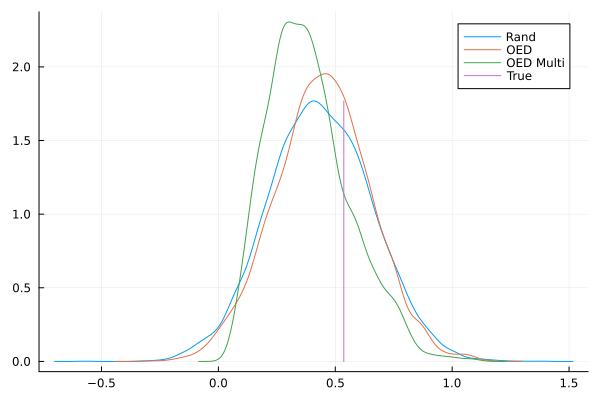

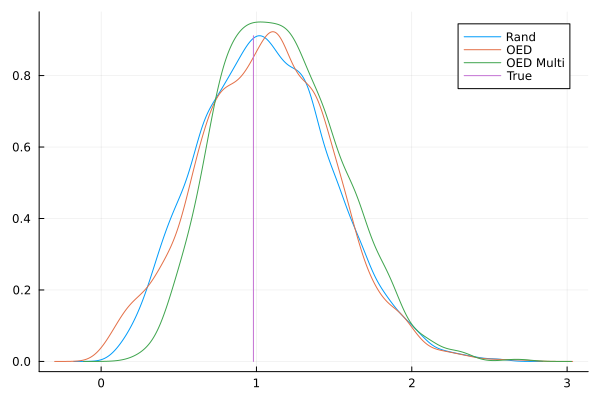

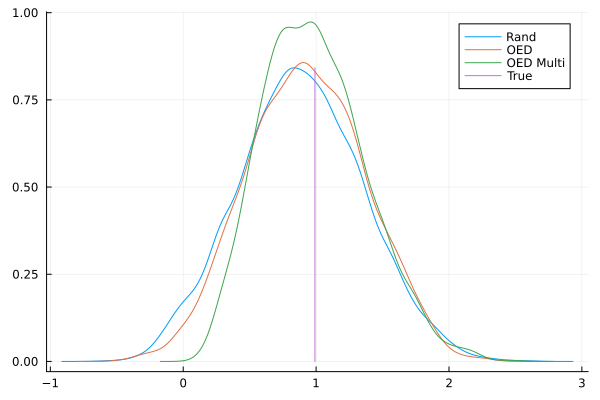

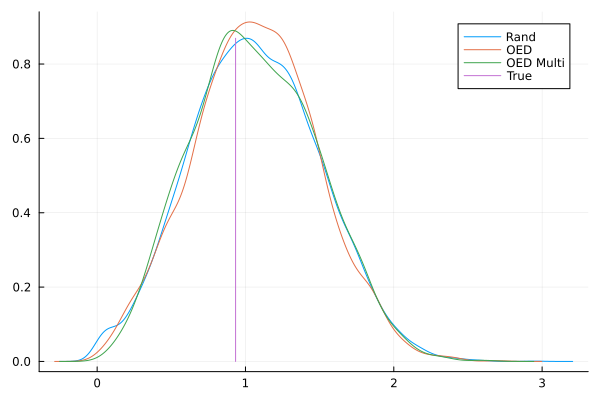

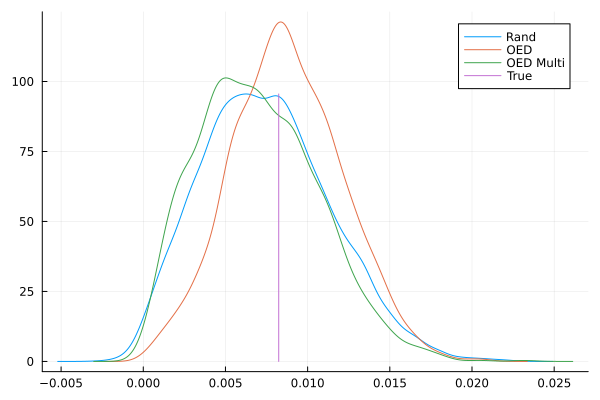

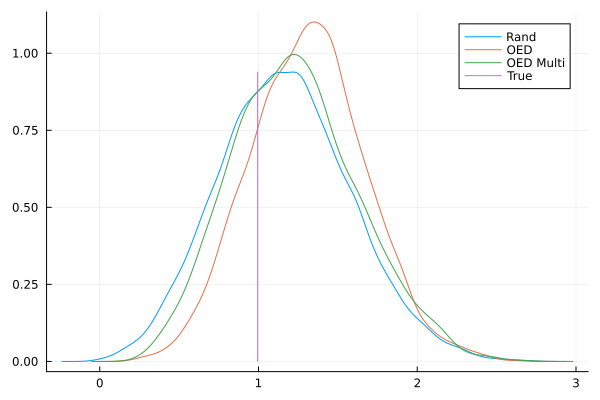

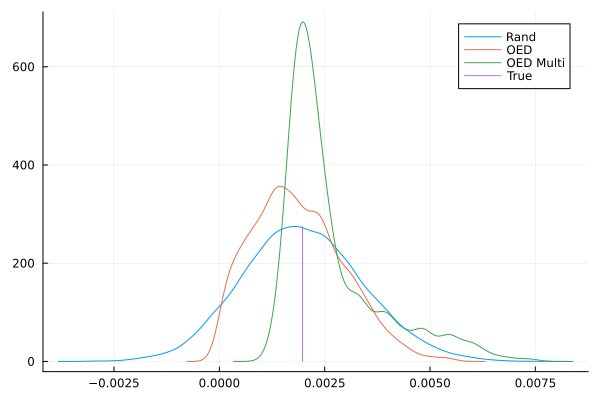

In [21]:
i= 4
for i in 3:12
    pps = plot(kde(posterR[:,i]), label = "Rand")
    plot!(kde(posterO[:,i]), label = "OED")
    plot!(kde(posterOM[:,i]), label = "OED Multi")

    plot!([trueP[i], trueP[i]],[0, maximum(kde(posterR[:,i]).density)], label = "True")

    display(pps)
end

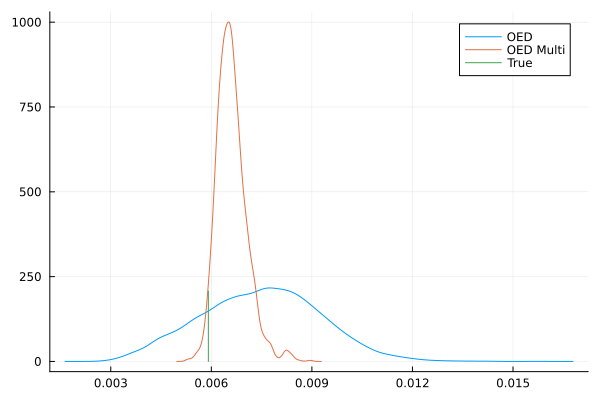

In [6]:
i = 3
pps = plot(kde(posterR[:,i]), label = "Rand")
plot(kde(posterO[:,i]), label = "OED")
plot!(kde(posterOM[:,i]), label = "OED Multi")

plot!([trueP[i], trueP[i]],[0, maximum(kde(posterR[:,i]).density)], label = "True")

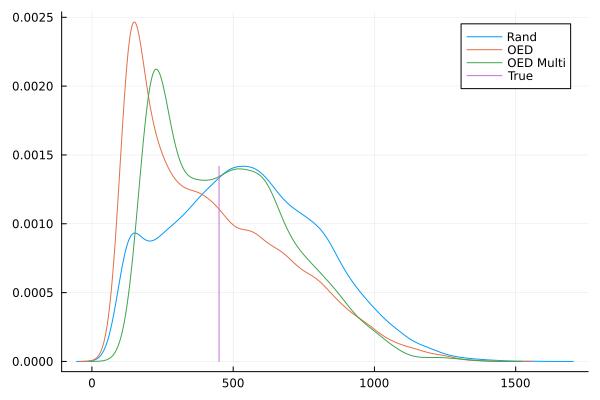

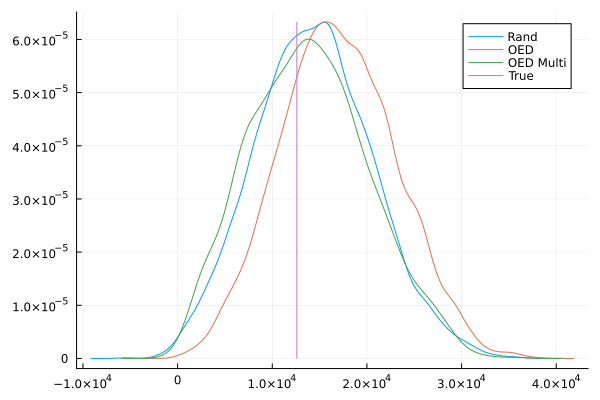

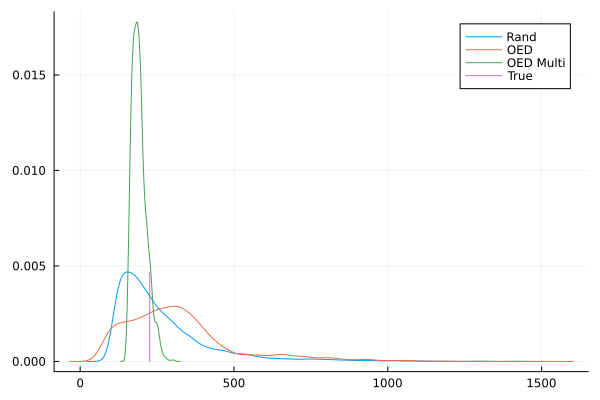

In [8]:
i= 4
for i in 1:3
    pps = plot(kde(posterR[:,i+13]), label = "Rand")
    plot!(kde(posterO[:,i+13]), label = "OED")
    plot!(kde(posterOM[:,i+13]), label = "OED Multi")

    plot!([InitsY0[i], InitsY0[i]],[0, maximum(kde(posterR[:,i+13]).density)], label = "True")

    display(pps)
end

# Sample Distance to True Theta

In [9]:
function dPSD_M(poster, trueP, upB, lwB)

    dPSD = zeros(size(poster));

    for i in 1:size(poster)[1]
        dPSD[i,:] = (poster[i,:] - trueP)./(upB - lwB);
    end

    dPSDM = sum(sqrt.(dPSD.^2), dims = 1)./size(dPSD)[1];

    return dPSD, dPSDM

end

dPSD_M (generic function with 1 method)

In [10]:
dPSDR, dPSDMR = dPSD_M(posterR, vcat(trueP, InitsY0), vcat(bounds[2], boundY0[2]), vcat(bounds[1], boundY0[1]));
dPSDO, dPSDMO = dPSD_M(posterO, vcat(trueP, InitsY0), vcat(bounds[2], boundY0[2]), vcat(bounds[1], boundY0[1]));
dPSDOM, dPSDMOM = dPSD_M(posterOM, vcat(trueP, InitsY0), vcat(bounds[2], boundY0[2]), vcat(bounds[1], boundY0[1]));

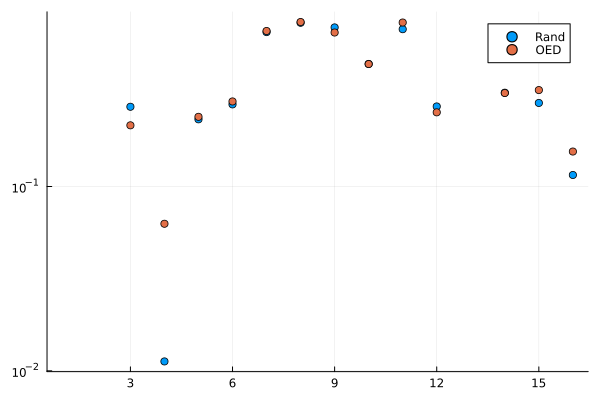

In [12]:
scatter(transpose(dPSDMR), label = "Rand", yaxis=:log)
scatter!(transpose(dPSDMO), label = "OED")#, yaxis=:log)
# scatter!(transpose(dPSDMOM), label = "OEDMult")#, yaxis=:log)

In [13]:
[sum(filter(!isnan, dPSDMR)), sum(filter(!isnan, dPSDMO)), sum(filter(!isnan, dPSDMOM))]

3-element Vector{Float64}:
 5.1532142969763965
 5.268381716543206
 4.566653977706735

In [14]:
[mean(filter(!isnan, dPSDMR)), mean(filter(!isnan, dPSDMO)), mean(filter(!isnan, dPSDMOM))]

3-element Vector{Float64}:
 0.3964010997674151
 0.40526013204178507
 0.3512810752082104

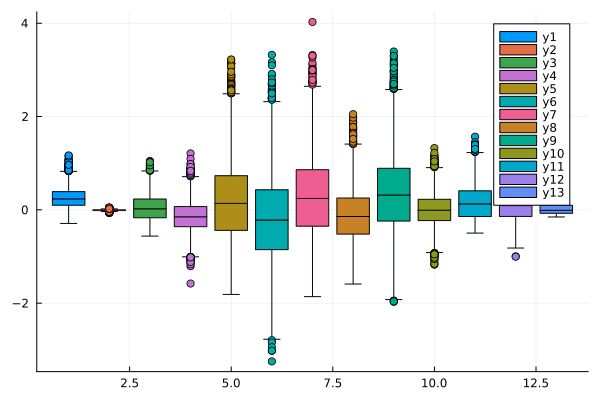

In [15]:
boxplot(hcat(dPSDR[:,3:12], dPSDR[:,14:end]))

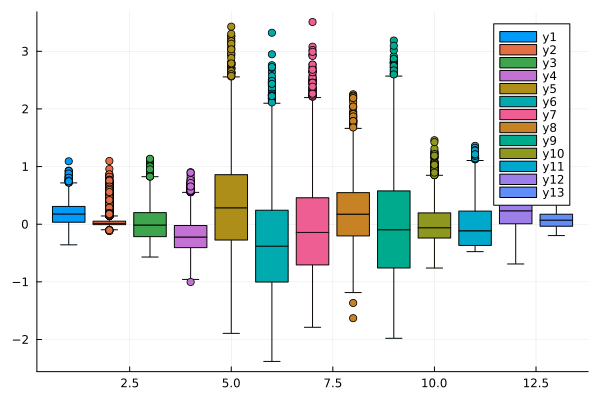

In [16]:
boxplot(hcat(dPSDO[:,3:12], dPSDO[:,14:end]))

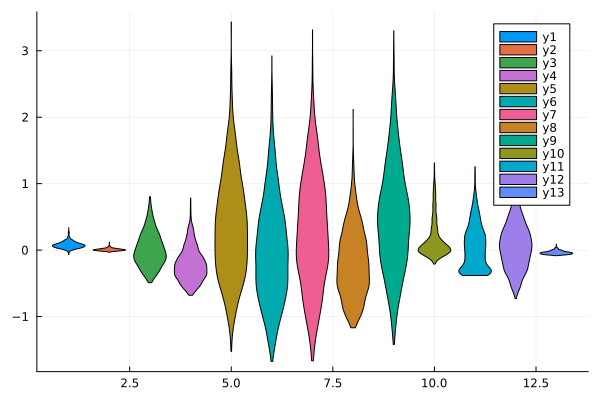

In [44]:
violin(hcat(dPSDOM[:,3:12], dPSDOM[:,14:end]))

# Covariance Matrix Determinant

The lower the metric, the better

In [17]:
# Prior
sts = [0.00275, 0.01375, 0.0225, 0.225, 0.475, 0.475, 0.475, 0.00425, 0.475, 0.00145, 260, 6400, 275];
log(det(Diagonal(ones(13)).*sts))

-10.50204958907828

In [19]:
# Posteriors
[log(det(cov(hcat(posterR[:,3:12], posterR[:,14:end])))), log(det(cov(hcat(posterO[:,3:12], posterO[:,14:end])))), log(det(cov(hcat(posterOM[:,3:12], posterOM[:,14:end]))))]

3-element Vector{Float64}:
 -32.31529906370681
 -29.16510123733144
 -45.73562945790777

# Entropy Difference

The higher the metric, the better

In [50]:
include("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\EntropyEstimationPosterior.jl")
using ScikitLearn.GridSearch
using ScikitLearnBase
using GaussianMixtures

In [61]:
mes = [0.0055, 0.0275, 0.045, 0.45, 0.95, 0.95, 0.95, 0.0085, 0.95, 0.0029, 650, 16000, 550];
sts = [0.00275, 0.01375, 0.0225, 0.225, 0.475, 0.475, 0.475, 0.00425, 0.475, 0.00145, 260, 6400, 275];

HPrior = entropy(MvNormal(mes, Diagonal(ones(13)).*sts));


13.195176137121603

In [82]:
grid_searchM1FR = ScikitLearnBase.fit!(GridSearchCV(GMM(n_components=10, kind=:full), 
        Dict(:n_components=>collect(1:20))), hcat(posterR[:,3:12], posterR[:,14:end]))

grid_searchM1FbR = ScikitLearnBase.fit!(GridSearchCV(GMM(n_components=grid_searchM1FR.best_estimator_.n*4, kind=:full), 
        Dict(:n_components=>collect(grid_searchM1FR.best_estimator_.n*4:grid_searchM1FR.best_estimator_.n*4))), hcat(posterR[:,3:12], posterR[:,14:end]))

GridSearchCV
  estimator: GMM{Float64, Vector{UpperTriangular{Float64, Matrix{Float64}}}}
  param_grid: Dict{Symbol, Vector{Int64}}
  scoring: Nothing nothing
  loss_func: Nothing nothing
  score_func: Nothing nothing
  fit_params: Dict{Any, Any}
  n_jobs: Int64 1
  iid: Bool true
  refit: Bool true
  cv: Nothing nothing
  verbose: Int64 0
  error_score: String "raise"
  scorer_: score (function of type typeof(ScikitLearnBase.score))
  best_params_: Dict{Symbol, Any}
  best_score_: Float64 -0.5818265593954325
  grid_scores_: Array{ScikitLearn.Skcore.CVScoreTuple}((1,))
  best_estimator_: GMM{Float64, Vector{UpperTriangular{Float64, Matrix{Float64}}}}


In [72]:
grid_searchM1FO = ScikitLearnBase.fit!(GridSearchCV(GMM(n_components=10, kind=:full), 
        Dict(:n_components=>collect(1:20))), hcat(posterO[:,3:12], posterO[:,14:end]))

grid_searchM1FbO = ScikitLearnBase.fit!(GridSearchCV(GMM(n_components=grid_searchM1FO.best_estimator_.n*4, kind=:full), 
        Dict(:n_components=>collect(grid_searchM1FO.best_estimator_.n*4:grid_searchM1FO.best_estimator_.n*4))), hcat(posterO[:,3:12], posterO[:,14:end]))

K-means converged with 3 iterations (objv = 2.9489480307882065e10)


┌ Info: Initializing GMM, 2 Gaussians diag covariance 13 dimensions using 5333 data points
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:79
┌ Info: K-means with 2000 data points using 3 iterations
│ 71.4 data points per parameter
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:141


K-means converged with 14 iterations (objv = 2.958755470721711e10)


┌ Info: Initializing GMM, 2 Gaussians diag covariance 13 dimensions using 5333 data points
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:79
┌ Info: K-means with 2000 data points using 14 iterations
│ 71.4 data points per parameter
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:141


K-means converged with 9 iterations (objv = 3.143319086822826e10)


┌ Info: Initializing GMM, 2 Gaussians diag covariance 13 dimensions using 5334 data points
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:79
┌ Info: K-means with 2000 data points using 9 iterations
│ 71.4 data points per parameter
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:141


K-means converged with 27 iterations (objv = 2.32507680078725e10)


┌ Info: Initializing GMM, 3 Gaussians diag covariance 13 dimensions using 5333 data points
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:79
┌ Info: K-means with 3000 data points using 27 iterations
│ 71.4 data points per parameter
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:141


K-means converged with 35 iterations (objv = 2.4330429652923035e10)


┌ Info: Initializing GMM, 3 Gaussians diag covariance 13 dimensions using 5333 data points
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:79
┌ Info: K-means with 3000 data points using 35 iterations
│ 71.4 data points per parameter
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:141


K-means converged with 36 iterations (objv = 2.5175094167356163e10)


┌ Info: Initializing GMM, 3 Gaussians diag covariance 13 dimensions using 5334 data points
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:79
┌ Info: K-means with 3000 data points using 36 iterations
│ 71.4 data points per parameter
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:141


K-means converged with 18 iterations (objv = 1.823171000933491e10)


┌ Info: Initializing GMM, 4 Gaussians diag covariance 13 dimensions using 5333 data points
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:79
┌ Info: K-means with 4000 data points using 18 iterations
│ 71.4 data points per parameter
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:141


K-means converged with 16 iterations (objv = 1.943944616562771e10)


┌ Info: Initializing GMM, 4 Gaussians diag covariance 13 dimensions using 5333 data points
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:79
┌ Info: K-means with 4000 data points using 16 iterations
│ 71.4 data points per parameter
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:141


K-means converged with 11 iterations (objv = 1.9692574477583145e10)


┌ Info: Initializing GMM, 4 Gaussians diag covariance 13 dimensions using 5334 data points
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:79
┌ Info: K-means with 4000 data points using 11 iterations
│ 71.4 data points per parameter
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:141


K-means terminated without convergence after 50 iterations (objv = 1.5860859069845907e10)


┌ Info: Initializing GMM, 5 Gaussians diag covariance 13 dimensions using 5333 data points
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:79
┌ Info: K-means with 5000 data points using 50 iterations
│ 71.4 data points per parameter
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:141


K-means converged with 20 iterations (objv = 1.6412414196989517e10)


┌ Info: Initializing GMM, 5 Gaussians diag covariance 13 dimensions using 5333 data points
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:79
┌ Info: K-means with 5000 data points using 20 iterations
│ 71.4 data points per parameter
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:141


K-means terminated without convergence after 50 iterations (objv = 1.6512503259753658e10)


┌ Info: Initializing GMM, 5 Gaussians diag covariance 13 dimensions using 5334 data points
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:79
┌ Info: K-means with 5000 data points using 50 iterations
│ 71.4 data points per parameter
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:141


K-means converged with 47 iterations (objv = 1.2010250750731e10)


┌ Info: Initializing GMM, 6 Gaussians diag covariance 13 dimensions using 5333 data points
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:79
┌ Info: K-means with 5333 data points using 47 iterations
│ 63.5 data points per parameter
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:141


K-means terminated without convergence after 50 iterations (objv = 1.2287492403883009e10)


┌ Info: Initializing GMM, 6 Gaussians diag covariance 13 dimensions using 5333 data points
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:79
┌ Info: K-means with 5333 data points using 50 iterations
│ 63.5 data points per parameter
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:141


K-means converged with 29 iterations (objv = 1.2911056359137043e10)


┌ Info: Initializing GMM, 6 Gaussians diag covariance 13 dimensions using 5334 data points
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:79
┌ Info: K-means with 5334 data points using 29 iterations
│ 63.5 data points per parameter
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:141


K-means terminated without convergence after 50 iterations (objv = 9.21628400395237e9)


┌ Info: Initializing GMM, 7 Gaussians diag covariance 13 dimensions using 5333 data points
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:79
┌ Info: K-means with 5333 data points using 50 iterations
│ 54.4 data points per parameter
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:141


K-means converged with 46 iterations (objv = 9.12068738008449e9)


┌ Info: Initializing GMM, 7 Gaussians diag covariance 13 dimensions using 5333 data points
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:79
┌ Info: K-means with 5333 data points using 46 iterations
│ 54.4 data points per parameter
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:141


K-means converged with 50 iterations (objv = 9.653061393996494e9)


┌ Info: Initializing GMM, 7 Gaussians diag covariance 13 dimensions using 5334 data points
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:79
┌ Info: K-means with 5334 data points using 50 iterations
│ 54.4 data points per parameter
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:141


K-means terminated without convergence after 50 iterations (objv = 7.229066035935663e9)


┌ Info: Initializing GMM, 8 Gaussians diag covariance 13 dimensions using 5333 data points
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:79
┌ Info: K-means with 5333 data points using 50 iterations
│ 47.6 data points per parameter
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:141


K-means terminated without convergence after 50 iterations (objv = 7.211062293523831e9)


┌ Info: Initializing GMM, 8 Gaussians diag covariance 13 dimensions using 5333 data points
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:79
┌ Info: K-means with 5333 data points using 50 iterations
│ 47.6 data points per parameter
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:141


K-means terminated without convergence after 50 iterations (objv = 7.929720643446567e9)


┌ Info: Initializing GMM, 8 Gaussians diag covariance 13 dimensions using 5334 data points
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:79
┌ Info: K-means with 5334 data points using 50 iterations
│ 47.6 data points per parameter
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:141


K-means terminated without convergence after 50 iterations (objv = 5.891215051812416e9)


┌ Info: Initializing GMM, 9 Gaussians diag covariance 13 dimensions using 5333 data points
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:79
┌ Info: K-means with 5333 data points using 50 iterations
│ 42.3 data points per parameter
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:141


K-means terminated without convergence after 50 iterations (objv = 5.83755334317634e9)


┌ Info: Initializing GMM, 9 Gaussians diag covariance 13 dimensions using 5333 data points
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:79
┌ Info: K-means with 5333 data points using 50 iterations
│ 42.3 data points per parameter
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:141


K-means converged with 20 iterations (objv = 6.143963375291498e9)


┌ Info: Initializing GMM, 9 Gaussians diag covariance 13 dimensions using 5334 data points
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:79
┌ Info: K-means with 5334 data points using 20 iterations
│ 42.3 data points per parameter
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:141


K-means converged with 44 iterations (objv = 4.903409290058931e9)


┌ Info: Initializing GMM, 10 Gaussians diag covariance 13 dimensions using 5333 data points
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:79
┌ Info: K-means with 5333 data points using 44 iterations
│ 38.1 data points per parameter
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:141


K-means converged with 26 iterations (objv = 4.980342353597676e9)


┌ Info: Initializing GMM, 10 Gaussians diag covariance 13 dimensions using 5333 data points
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:79
┌ Info: K-means with 5333 data points using 26 iterations
│ 38.1 data points per parameter
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:141


K-means converged with 32 iterations (objv = 5.258332199562641e9)


┌ Info: Initializing GMM, 10 Gaussians diag covariance 13 dimensions using 5334 data points
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:79
┌ Info: K-means with 5334 data points using 32 iterations
│ 38.1 data points per parameter
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:141


K-means converged with 17 iterations (objv = 4.0527236976336336e9)


┌ Info: Initializing GMM, 11 Gaussians diag covariance 13 dimensions using 5333 data points
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:79
┌ Info: K-means with 5333 data points using 17 iterations
│ 34.6 data points per parameter
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:141


K-means converged with 42 iterations (objv = 4.0837289087757883e9)


┌ Info: Initializing GMM, 11 Gaussians diag covariance 13 dimensions using 5333 data points
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:79


K-means terminated without convergence after 50 iterations (objv = 4.252373062163559e9)


┌ Info: K-means with 5333 data points using 42 iterations
│ 34.6 data points per parameter
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:141
┌ Info: Initializing GMM, 11 Gaussians diag covariance 13 dimensions using 5334 data points
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:79
┌ Info: K-means with 5334 data points using 50 iterations
│ 34.6 data points per parameter
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:141


K-means terminated without convergence after 50 iterations (objv = 3.445487109683675e9)


┌ Info: Initializing GMM, 12 Gaussians diag covariance 13 dimensions using 5333 data points
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:79
┌ Info: K-means with 5333 data points using 50 iterations
│ 31.7 data points per parameter
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:141


K-means terminated without convergence after 50 iterations (objv = 3.522066792282632e9)


┌ Info: Initializing GMM, 12 Gaussians diag covariance 13 dimensions using 5333 data points
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:79
┌ Info: K-means with 5333 data points using 50 iterations
│ 31.7 data points per parameter
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:141


K-means terminated without convergence after 50 iterations (objv = 3.624387911250473e9)


┌ Info: Initializing GMM, 12 Gaussians diag covariance 13 dimensions using 5334 data points
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:79
┌ Info: K-means with 5334 data points using 50 iterations
│ 31.8 data points per parameter
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:141


K-means terminated without convergence after 50 iterations (objv = 3.041874474618066e9)


┌ Info: Initializing GMM, 13 Gaussians diag covariance 13 dimensions using 5333 data points
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:79
┌ Info: K-means with 5333 data points using 50 iterations
│ 29.3 data points per parameter
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:141


K-means terminated without convergence after 50 iterations (objv = 3.046131798878625e9)


┌ Info: Initializing GMM, 13 Gaussians diag covariance 13 dimensions using 5333 data points
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:79
┌ Info: K-means with 5333 data points using 50 iterations
│ 29.3 data points per parameter
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:141


K-means terminated without convergence after 50 iterations (objv = 3.2942086945400434e9)


┌ Info: Initializing GMM, 13 Gaussians diag covariance 13 dimensions using 5334 data points
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:79
┌ Info: K-means with 5334 data points using 50 iterations
│ 29.3 data points per parameter
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:141


K-means converged with 23 iterations (objv = 2.6959565446828594e9)


┌ Info: Initializing GMM, 14 Gaussians diag covariance 13 dimensions using 5333 data points
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:79
┌ Info: K-means with 5333 data points using 23 iterations
│ 27.2 data points per parameter
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:141


K-means terminated without convergence after 50 iterations (objv = 2.6575250894182234e9)


┌ Info: Initializing GMM, 14 Gaussians diag covariance 13 dimensions using 5333 data points
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:79
┌ Info: K-means with 5333 data points using 50 iterations
│ 27.2 data points per parameter
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:141


K-means converged with 48 iterations (objv = 2.773678226118213e9)


┌ Info: Initializing GMM, 14 Gaussians diag covariance 13 dimensions using 5334 data points
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:79
┌ Info: K-means with 5334 data points using 48 iterations
│ 27.2 data points per parameter
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:141
┌ Info: Initializing GMM, 15 Gaussians diag covariance 13 dimensions using 5333 data points
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:79


K-means terminated without convergence after 50 iterations (objv = 2.4112033611212487e9)


┌ Info: K-means with 5333 data points using 50 iterations
│ 25.4 data points per parameter
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:141


K-means converged with 41 iterations (objv = 2.4296891859799786e9)


┌ Info: Initializing GMM, 15 Gaussians diag covariance 13 dimensions using 5333 data points
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:79
┌ Info: K-means with 5333 data points using 41 iterations
│ 25.4 data points per parameter
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:141


K-means terminated without convergence after 50 iterations (objv = 2.619741518178186e9)


┌ Info: Initializing GMM, 15 Gaussians diag covariance 13 dimensions using 5334 data points
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:79
┌ Info: K-means with 5334 data points using 50 iterations
│ 25.4 data points per parameter
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:141


K-means terminated without convergence after 50 iterations (objv = 2.300738700820174e9)


┌ Info: Initializing GMM, 16 Gaussians diag covariance 13 dimensions using 5333 data points
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:79
┌ Info: K-means with 5333 data points using 50 iterations
│ 23.8 data points per parameter
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:141


K-means terminated without convergence after 50 iterations (objv = 2.169915196955026e9)


┌ Info: Initializing GMM, 16 Gaussians diag covariance 13 dimensions using 5333 data points
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:79
┌ Info: K-means with 5333 data points using 50 iterations
│ 23.8 data points per parameter
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:141


K-means terminated without convergence after 50 iterations (objv = 2.285452911071987e9)


┌ Info: Initializing GMM, 16 Gaussians diag covariance 13 dimensions using 5334 data points
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:79
┌ Info: K-means with 5334 data points using 50 iterations
│ 23.8 data points per parameter
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:141


K-means converged with 37 iterations (objv = 2.0144035478849275e9)


┌ Info: Initializing GMM, 17 Gaussians diag covariance 13 dimensions using 5333 data points
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:79
┌ Info: K-means with 5333 data points using 37 iterations
│ 22.4 data points per parameter
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:141


K-means converged with 49 iterations (objv = 2.012392836323167e9)


┌ Info: Initializing GMM, 17 Gaussians diag covariance 13 dimensions using 5333 data points
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:79
┌ Info: K-means with 5333 data points using 49 iterations
│ 22.4 data points per parameter
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:141


K-means converged with 50 iterations (objv = 2.0366687384361556e9)


┌ Info: Initializing GMM, 17 Gaussians diag covariance 13 dimensions using 5334 data points
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:79
┌ Info: K-means with 5334 data points using 50 iterations
│ 22.4 data points per parameter
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:141


K-means terminated without convergence after 50 iterations (objv = 1.8598398866230311e9)


┌ Info: Initializing GMM, 18 Gaussians diag covariance 13 dimensions using 5333 data points
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:79
┌ Info: K-means with 5333 data points using 50 iterations
│ 21.2 data points per parameter
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:141


K-means terminated without convergence after 50 iterations (objv = 1.8840875008361287e9)


┌ Info: Initializing GMM, 18 Gaussians diag covariance 13 dimensions using 5333 data points
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:79
┌ Info: K-means with 5333 data points using 50 iterations
│ 21.2 data points per parameter
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:141


K-means terminated without convergence after 50 iterations (objv = 1.9700271382912726e9)


┌ Info: Initializing GMM, 18 Gaussians diag covariance 13 dimensions using 5334 data points
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:79
┌ Info: K-means with 5334 data points using 50 iterations
│ 21.2 data points per parameter
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:141


K-means converged with 43 iterations (objv = 1.7179936945091968e9)


┌ Info: Initializing GMM, 19 Gaussians diag covariance 13 dimensions using 5333 data points
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:79
┌ Info: K-means with 5333 data points using 43 iterations
│ 20.0 data points per parameter
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:141


K-means terminated without convergence after 50 iterations (objv = 1.724200889865495e9)


┌ Info: Initializing GMM, 19 Gaussians diag covariance 13 dimensions using 5333 data points
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:79
┌ Info: K-means with 5333 data points using 50 iterations
│ 20.0 data points per parameter
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:141


K-means converged with 30 iterations (objv = 1.7311307302433872e9)


┌ Info: Initializing GMM, 19 Gaussians diag covariance 13 dimensions using 5334 data points
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:79
┌ Info: K-means with 5334 data points using 30 iterations
│ 20.1 data points per parameter
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:141


K-means converged with 39 iterations (objv = 1.564237062327931e9)


┌ Info: Initializing GMM, 20 Gaussians diag covariance 13 dimensions using 5333 data points
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:79
┌ Info: K-means with 5333 data points using 39 iterations
│ 19.0 data points per parameter
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:141


K-means terminated without convergence after 50 iterations (objv = 1.6677028582854166e9)


┌ Info: Initializing GMM, 20 Gaussians diag covariance 13 dimensions using 5333 data points
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:79
┌ Info: K-means with 5333 data points using 50 iterations
│ 19.0 data points per parameter
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:141


K-means converged with 23 iterations (objv = 1.6300612263679957e9)


┌ Info: Initializing GMM, 20 Gaussians diag covariance 13 dimensions using 5334 data points
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:79
┌ Info: K-means with 5334 data points using 23 iterations
│ 19.1 data points per parameter
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:141


K-means terminated without convergence after 50 iterations (objv = 1.2246581475458992e10)


┌ Info: Initializing GMM, 7 Gaussians diag covariance 13 dimensions using 8000 data points
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:79
┌ Info: K-means with 7000 data points using 50 iterations
│ 71.4 data points per parameter
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:141


K-means converged with 31 iterations (objv = 1.0121148877517959e9)


┌ Info: Initializing GMM, 28 Gaussians diag covariance 13 dimensions using 5333 data points
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:79
┌ Info: K-means with 5333 data points using 31 iterations
│ 13.6 data points per parameter
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:141
┌ Warning: Too low occupancy count 0.0 for Gausian 4
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:266
┌ Warning: Too low occupancy count 0.0 for Gausian 9
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:266
┌ Warning: 26 pathological elements normalized
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:69
┌ Warning: Too low occupancy count 0.0 for Gausian 4
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:266
┌ Warning: Too low occupancy count 0.0 for Gausian 9
└ 

K-means terminated without convergence after 50 iterations (objv = 1.02985447386677e9)


┌ Info: Initializing GMM, 28 Gaussians diag covariance 13 dimensions using 5333 data points
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:79
┌ Info: K-means with 5333 data points using 50 iterations
│ 13.6 data points per parameter
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:141
┌ Warning: Too low occupancy count 0.0 for Gausian 23
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:266
┌ Warning: 13 pathological elements normalized
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:69
┌ Warning: Too low occupancy count 0.0 for Gausian 23
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:266
┌ Warning: 13 pathological elements normalized
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:69
┌ Warning: Too low occupancy count 0.0 for Gausian 23
└ @ Ga

K-means converged with 35 iterations (objv = 1.0349930537922547e9)


┌ Info: Initializing GMM, 28 Gaussians diag covariance 13 dimensions using 5334 data points
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:79
┌ Info: K-means with 5334 data points using 35 iterations
│ 13.6 data points per parameter
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:141
┌ Info: Initializing GMM, 28 Gaussians diag covariance 13 dimensions using 8000 data points
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:79


K-means converged with 50 iterations (objv = 1.6043046311652339e9)


┌ Info: K-means with 8000 data points using 50 iterations
│ 20.4 data points per parameter
└ @ GaussianMixtures C:\Users\dgomez\.julia\packages\GaussianMixtures\yHlNS\src\train.jl:141


GridSearchCV
  estimator: GMM{Float64, Vector{UpperTriangular{Float64, Matrix{Float64}}}}
  param_grid: Dict{Symbol, Vector{Int64}}
  scoring: Nothing nothing
  loss_func: Nothing nothing
  score_func: Nothing nothing
  fit_params: Dict{Any, Any}
  n_jobs: Int64 1
  iid: Bool true
  refit: Bool true
  cv: Nothing nothing
  verbose: Int64 0
  error_score: String "raise"
  scorer_: score (function of type typeof(ScikitLearnBase.score))
  best_params_: Dict{Symbol, Any}
  best_score_: Float64 -0.06543218619440139
  grid_scores_: Array{ScikitLearn.Skcore.CVScoreTuple}((1,))
  best_estimator_: GMM{Float64, Vector{UpperTriangular{Float64, Matrix{Float64}}}}


In [83]:
comps = Array{Any,1}(undef,2);
weis = Array{Any,1}(undef,2);
meaas = Array{Any,1}(undef,2);
covas = Array{Any,1}(undef,2);

# Get and store best results
comps[1] = length(grid_searchM1FbR.best_estimator_.w); # Number of components
weis[1] = grid_searchM1FbR.best_estimator_.w; # Weights for each component
meaas[1] = grid_searchM1FbR.best_estimator_.μ; # Means for each component
covas[1] = [inv(Matrix(grid_searchM1FbR.best_estimator_.Σ[i]))*inv(Matrix(grid_searchM1FbR.best_estimator_.Σ[i])') 
    for i in 1:length(grid_searchM1FbR.best_estimator_.Σ)]; # Covariance Matrix for each component

comps[2] = length(grid_searchM1FbO.best_estimator_.w); # Number of components
weis[2] = grid_searchM1FbO.best_estimator_.w; # Weights for each component
meaas[2] = grid_searchM1FbO.best_estimator_.μ; # Means for each component
covas[2] = [inv(Matrix(grid_searchM1FbO.best_estimator_.Σ[i]))*inv(Matrix(grid_searchM1FbO.best_estimator_.Σ[i])') 
    for i in 1:length(grid_searchM1FbO.best_estimator_.Σ)];



28-element Vector{Matrix{Float64}}:
 [3.5751472870502277e-7 -7.523631107857662e-7 … 0.10884742265650989 -0.006635322865396379; -7.523631107857662e-7 2.435338863583963e-6 … -0.31793513913396554 -0.009664093217232014; … ; 0.10884742265650989 -0.31793513913396554 … 1.527164204650462e6 -8175.839490635328; -0.006635322865396379 -0.009664093217232014 … -8175.839490635328 27227.30492999166]
 [6.174119545325171e-7 -3.094491419314216e-6 … 0.1214079064871073 -0.0014391295454636629; -3.094491419314216e-6 2.2299040262954318e-5 … -0.5659950126064366 -0.08581258267707204; … ; 0.1214079064871073 -0.5659950126064366 … 1.1941296905661824e6 8841.388712814087; -0.0014391295454636629 -0.08581258267707204 … 8841.388712814087 22336.16623256368]
 [6.532785202826242e-7 -2.15327399234955e-6 … 0.022244264490346718 0.00869362478871016; -2.15327399234955e-6 1.0091493231095602e-5 … 0.22593157872952913 -0.10488958405760493; … ; 0.022244264490346718 0.22593157872952913 … 680226.2636557667 1674.0371223024483; 0.00869

In [90]:
H_U_Post = Array{Any,1}(undef,2);
H_L_Post = Array{Any,1}(undef,2);
H_Post = Array{Any,1}(undef,2);

[H_U_Post[i] = H_Upper(weis[i], covas[i]) for i in 1:2];
[H_L_Post[i] = H_Lower(weis[i], covas[i], meaas[i]) for i in 1:2];
[H_Post[i] = H_est(comps[i], weis[i], meaas[i], covas[i]) for i in 1:2];

In [135]:
H_Post

2-element Vector{Any}:
  -4.008070419862025
 -10.65930164578086

In [139]:
println(string("              |     H Lower Bound      |            H            |      H Upper Bound      |"))
println("--------------------------------------------------------------------------------------------")
println(string("|    Rand     |      ",round(H_L_Post[1], digits = 8),"      |      ",round(H_Post[1], digits = 9),"      |      ",round(H_U_Post[1], digits = 8),"       |"))
println("------------------------------------------------------------------------------------------")
println(string("|    OED      |      ",round(H_L_Post[2], digits = 8),"      |      ",round(H_Post[2], digits = 9),"      |      ",round(H_U_Post[2], digits = 9),"      |"))
println("------------------------------------------------------------------------------------------")


In [140]:
Hpri = [HPrior,HPrior];
H_gain = [Hpri[i]-H_Post[i] for i in 1:2];

In [144]:
println(string("              |      Entropy Gain      |"))
println("----------------------------------------")
println(string("|    Mod 1    |      ",round(H_gain[1], digits = 9),"      |"))
println("----------------------------------------")
println(string("|    Mod 2    |      ",round(H_gain[2], digits = 9),"      |"))
println("----------------------------------------")


In [142]:
H_gain

2-element Vector{Float64}:
 17.20324655698363
 23.854477782902464

In [28]:
posterO

2985×16 Matrix{Float64}:
 48.0  55.0  0.224103  0.018162   …  15.0  228.282  10055.4   169.904
 48.0  55.0  0.233126  0.0180392     15.0  842.983  19104.6    74.6676
 48.0  55.0  0.184748  0.0181701     15.0  778.527  14297.6    70.81
 48.0  55.0  0.356566  0.0186476     15.0  761.015  12151.8   105.466
 48.0  55.0  0.505433  0.018019      15.0  595.497   5579.63   89.9824
 48.0  55.0  0.12434   0.0186984  …  15.0  135.872  23278.7   148.301
 48.0  55.0  0.538225  0.0181359     15.0  322.68    3540.02  158.818
 48.0  55.0  0.520334  0.0181636     15.0  146.159  18458.1   208.002
 48.0  55.0  0.145441  0.0186836     15.0  665.182  20264.7    97.1131
 48.0  55.0  0.517392  0.0178624     15.0  137.135  11823.5   152.725
  ⋮                               ⋱                             ⋮
 48.0  55.0  0.710551  0.018321      15.0  393.225  21273.0   105.907
 48.0  55.0  0.438772  0.0184872     15.0  425.336  16989.0   130.197
 48.0  55.0  0.290557  0.0183893     15.0  498.469   9722.23   65.6

In [35]:
include("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\BayesianInference\\FunctionsBayesInfs.jl")
include("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\InitalParameterFitPriorDef\\ModelFunctionsAll.jl")
include("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ComputationalBayesianOED\\FunctionsBayesOED.jl")

redSamples (generic function with 2 methods)

In [55]:
Nexp = 4;

Random.seed!(46597557);
PyrCons = round.(rand(Uniform(0,40), Nexp), digits = 1).*1000

4-element Vector{Float64}:
  4900.0
 30400.0
 10400.0
 16000.0

In [56]:
dat32mM = Matrix(CSV.read("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ProcessedData\\4Mil_Dat.csv", DataFrame));

In [57]:
tsC2 = dat32mM[:,1]
ts = 0:tsC2[end];

ivssAll = Array{Any}(undef, Nexp);
for i in 1:Nexp
    ivssAll[i] = [PyrCons[i], 0, 0, InitsY0[1], InitsY0[2], InitsY0[3], 0, 0, 0, 0, 0, PyrCons[i], 0, PyrCons[i]*(trueP[end]*0.12)];;
end
samps = convert.(Int, tsC2);


In [62]:
mainpath = "C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ComputationalBayesianOED\\PseudoData\\";
i = 3;
paths = [mainpath*"CompRepr_OED"*string(i)*"_Observables_Pyr"*(string(0.9))*"mM.csv"]

1-element Vector{String}:
 "C:\\IBECPostDocDrive\\2024_01_16_" ⋯ 74 bytes ⋯ "r_OED3_Observables_Pyr0.9mM.csv"

In [63]:
Random.seed!(231549);
global dat = restructDatInfCompRep(paths, rand(Uniform(boundY0[1][1],boundY0[2][1])), rand(Uniform(boundY0[1][2],boundY0[2][2])), rand(Uniform(boundY0[1][3],boundY0[2][3])))

Dict{String, Any} with 14 entries:
  "Means"  => [1620.0; 1220.71; … ; -1.86245; -1.83556;;; 0.0; 12.7165; … ; 2.4…
  "stsl"   => [78;;]
  "obSta"  => [1 2]
  "sts"    => [0; 15; … ; 390; 395;;]
  "obser"  => 2
  "Y0us"   => [729.602; 0.0; … ; 0.0; 1620.0;;]
  "ts"     => [1.0e-20; 1.0; … ; 394.0; 395.0;;]
  "itp"    => [0.0]
  "ncells" => [0;;]
  "stslm"  => 78
  "tml"    => 396
  "Erros"  => [194.4; 146.485; … ; 1.0; 1.0;;; 1.0; 1.0; … ; 1.0; 1.0]
  "m"      => 1
  "nts"    => [395;;]

In [64]:
simsPoster = Array{Any}(undef, 2985);


for i in 1:2985
    tsC2 = dat["sts"];
    ts = 0:tsC2[end];
    ivss = [dat["Means"][1,1,1]/(posterO[i,13]*0.12), 0, 0, posterO[i,14], posterO[i,15], posterO[i,16], 0, 0, 0, 0, 0, dat["Means"][1,1,1]/(posterO[i,13]*0.12), 0, dat["Means"][1,1,1]];;
    samps = convert.(Int, tsC2);

    SimulsAll, SimulsAll2, SimulsAll3 = PyruvateHP_NMR_SolveAllCp(ts, vcat(posterO[i,1:13], 0), ivss, samps);

    simsPoster[i] = SimulsAll;
end

In [65]:
# Dims = Up/Down, Observable, Experiment
PostQuant = Array{Any}(undef,2,1,1);
lacPostSims = zeros(size(simsPoster[1])[1], 2985)
[lacPostSims[:,i] = simsPoster[i][:,13,1] for i in 1:2985 ];

for k in 1:1
    for m in 1:1
        PostQuant[1,k,m] = [percentile(lacPostSims[j,:], 99.5) for j in 1:size(lacPostSims)[1]]; # Up
        PostQuant[2,k,m] = [percentile(lacPostSims[j,:], 0.5 ) for j in 1:size(lacPostSims)[1]]; # Down
    end
end


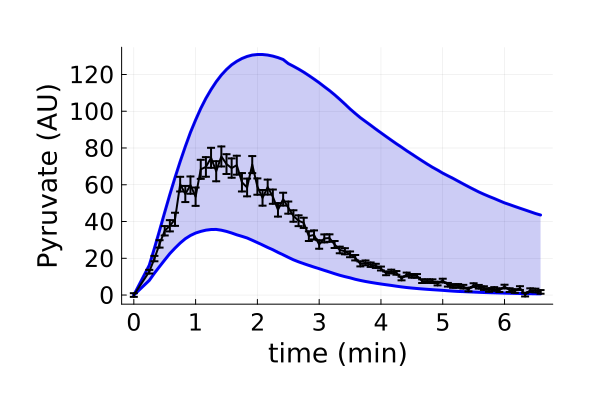

In [66]:
pr = plot(tsC2./60, PostQuant[1], label = "", color = "blue", linewidth = 3,
    margin=10Plots.mm,xtickfont=font(16), ytickfont=font(16), guidefont=font(18), titlefont=font(18),
    xlabel = "time (min)", ylabel = "Pyruvate (AU)")
  plot!(tsC2./60, PostQuant[2], label = "", color = "blue", linewidth = 3)
  plot!(tsC2./60, PostQuant[1], fillrange=PostQuant[2], label="", color="blue3", fillalpha=0.2)

  plot!(dat["sts"]./60, dat["Means"][:,1,2], yerror = dat["Erros"][:,1,2], linewidth = 2, colour = "black", label = "")

In [ ]:
trueP = [48.0, 55.0,0.005911,0.01832,0.042171,0.5365,0.98047,0.991257,0.93335,0.008241,0.9943848,0.001974,   15];

bounds = [[48, 55, 0.001, 0.005, 0.01, 0.1, 0.7, 0.7, 0.7, 0.005, 0.7, 0.0008, 15],
          [48, 55, 0.01, 0.05, 0.08, 0.8, 1.2, 1.2, 1.2, 0.012, 1.2, 0.005, 15]];

InitsY0 = [450, 12599, 226];


In [284]:
51 % 2

1

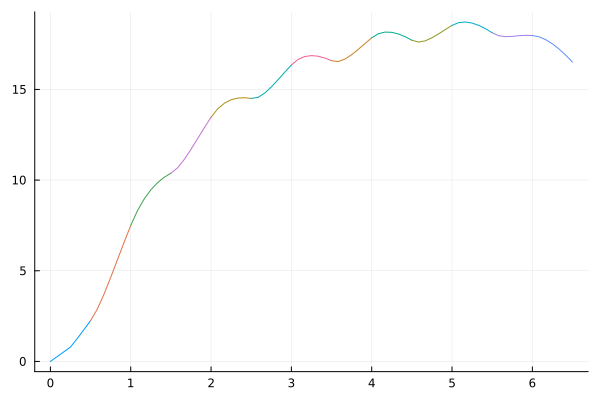

In [302]:
sims = Array{Any}(undef, 13,2)

tsC2 = dat["sts"][1:5];
ts = 0:tsC2[end];
ivss = [100, 0, 0, mean(InitsY0[1]), mean(InitsY0[2]), mean(InitsY0[3]), 0, 0, 0, 0, 0, 100, 0, 100*(posterO[1,13]*0.12)];;
samps = convert.(Int, tsC2);

SimulsAll, SimulsAll2, SimulsAll3 = PyruvateHP_NMR_SolveAllCp(ts, vcat(trueP, 0), ivss, samps);
sims[1,1] = tsC2;
sims[1,2] = SimulsAll;

tmpin = 5;
tmpin2 = 30;
for i in 2:13
    tsC2s2 = dat["sts"][tmpin:tmpin+6];
    tmpin = tmpin+6;
    tss2 = 0:dat["sts"][5];

    ivsss2 = sims[i-1,2][end,:,1];
    ivsss2[1] = ivsss2[1]*1.3

    if i % 2 == 1
        ivsss2[1] = ivsss2[1]/2;
    else
        ivsss2[1] = ivsss2[1]+(0.1*1000)
    end


    sampss2 = convert.(Int, tsC2s2.-tmpin2);
    tmpin2 = tmpin2+30;

    SimulsAlls2, SimulsAll2s2, SimulsAll3s2 = PyruvateHP_NMR_SolveAllCp(tss2, vcat(trueP, 0), ivsss2, sampss2);
    sims[i,1] = tsC2s2;
    sims[i,2] = SimulsAlls2;
end




ppt = plot(sims[1,1]./60, sims[1,2][:,11,1], label = "")
for i in 2:13
    plot!(sims[i,1]./60, sims[i,2][:,11,1], label = "")
end
display(ppt)




In [307]:
dat["sts"][11:23]

13-element Vector{Int64}:
  60
  65
  70
  75
  80
  85
  90
  95
 100
 105
 110
 115
 120

In [321]:
tsC2s2.-tmpin2

13-element Vector{Int64}:
  0
  5
 10
 15
 20
 25
 30
 35
 40
 45
 50
 55
 60

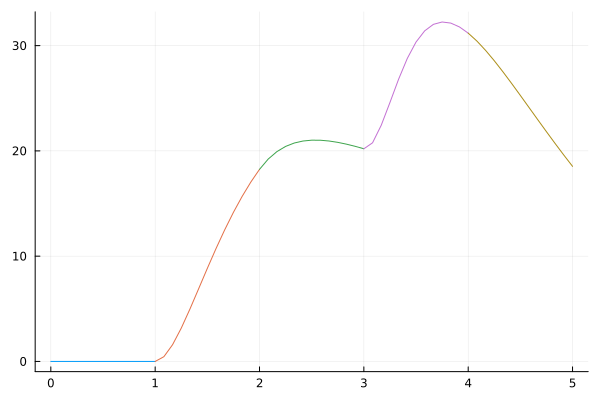

In [348]:
sims = Array{Any}(undef, 5,2)

tsC2 = dat["sts"][1:11];
ts = 0:tsC2[end];
ivss = [0, 0, 0, mean(InitsY0[1]), mean(InitsY0[2]), mean(InitsY0[3]), 0, 0, 0, 0, 0, 0, 0, 0*(posterO[1,13]*0.12)];;
samps = convert.(Int, tsC2);

SimulsAll, SimulsAll2, SimulsAll3 = PyruvateHP_NMR_SolveAllCp(ts, vcat(trueP, 0), ivss, samps);
sims[1,1] = tsC2;
sims[1,2] = SimulsAll;



tmpin = 11;
tmpin2 = 60;
for i in 2:5
    tsC2s2 = dat["sts"][tmpin:tmpin+12];
    tmpin = tmpin+12;
    tss2 = 0:dat["sts"][11];

    ivsss2 = sims[i-1,2][end,:,1];
    # ivsss2[1] = ivsss2[1]*1.3

    # if i % 2 == 1
    #     ivsss2[1] = ivsss2[1]/2;
    # else
    #     ivsss2[1] = ivsss2[1]+(0.1*1000)
    # end
    if i == 2
        ivsss2[1] = 0.4*1000
    elseif i == 3
        ivsss2[1] = 0.2*1000
    elseif i == 4
        ivsss2[1] = 1*1000
    elseif i == 5
        ivsss2[1] = 0.5*1000
    end


    sampss2 = convert.(Int, tsC2s2.-tmpin2);
    tmpin2 = tmpin2+60;

    SimulsAlls2, SimulsAll2s2, SimulsAll3s2 = PyruvateHP_NMR_SolveAllCp(tss2, vcat(trueP, 0), ivsss2, sampss2);
    sims[i,1] = tsC2s2;
    sims[i,2] = SimulsAlls2;
end




ppt = plot(sims[1,1]./60, sims[1,2][:,11,1], label = "")
for i in 2:5
    plot!(sims[i,1]./60, sims[i,2][:,11,1], label = "")
end
display(ppt)


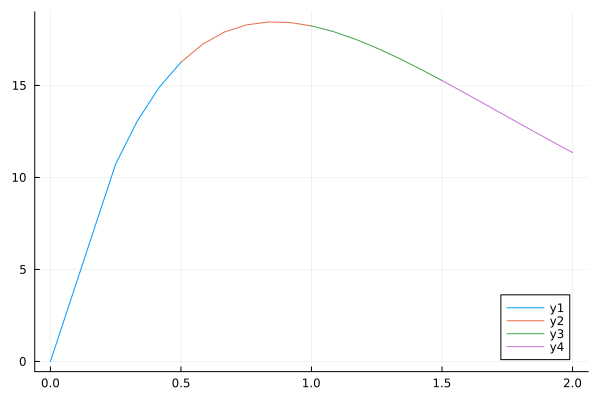

In [250]:
tsC2 = dat["sts"][1:5];
ts = 0:tsC2[end];
ivss = [40000, 0, 0, mean(InitsY0[1]), mean(InitsY0[2]), mean(InitsY0[3]), 0, 0, 0, 0, 0, 40000, 0, 40000*(posterO[1,13]*0.12)];;
samps = convert.(Int, tsC2);

SimulsAll, SimulsAll2, SimulsAll3 = PyruvateHP_NMR_SolveAllCp(ts, vcat(trueP, 0), ivss, samps);



tsC2s2 = dat["sts"][5:11];
tss2 = 0:dat["sts"][5];
# ivss = [40000, 0, 0, mean(InitsY0[1]), mean(InitsY0[2]), mean(InitsY0[3]), 0, 0, 0, 0, 0, 40000, 0, 40000*(posterO[1,13]*0.12)];;
ivsss2 = SimulsAll[end,:,1]
# ivsss2[1] = ivsss2[1]/5;
sampss2 = convert.(Int, tsC2s2.-30);

SimulsAlls2, SimulsAll2s2, SimulsAll3s2 = PyruvateHP_NMR_SolveAllCp(tss2, vcat(trueP, 0), ivsss2, sampss2);


tsC2s3 = dat["sts"][11:17];
tss3 = 0:dat["sts"][5];
# ivss = [40000, 0, 0, mean(InitsY0[1]), mean(InitsY0[2]), mean(InitsY0[3]), 0, 0, 0, 0, 0, 40000, 0, 40000*(posterO[1,13]*0.12)];;
ivsss3 = SimulsAlls2[end,:,1]
# ivsss3[1] = ivsss3[1]/5;
sampss3 = convert.(Int, tsC2s3.-60);

SimulsAlls3, SimulsAll2s3, SimulsAll3s3 = PyruvateHP_NMR_SolveAllCp(tss3, vcat(trueP, 0), ivsss3, sampss3);



tsC2s4 = dat["sts"][17:23];
tss4 = 0:dat["sts"][5];
# ivss = [40000, 0, 0, mean(InitsY0[1]), mean(InitsY0[2]), mean(InitsY0[3]), 0, 0, 0, 0, 0, 40000, 0, 40000*(posterO[1,13]*0.12)];;
ivsss4 = SimulsAlls3[end,:,1]
# ivsss3[1] = ivsss3[1]/5;
sampss4 = convert.(Int, tsC2s4.-90);

SimulsAlls4, SimulsAll2s4, SimulsAll3s4 = PyruvateHP_NMR_SolveAllCp(tss4, vcat(trueP, 0), ivsss4, sampss4);








plot(tsC2./60, SimulsAll[:,11,1])
plot!(tsC2s2./60, SimulsAlls2[:,11,1])
plot!(tsC2s3./60, SimulsAlls3[:,11,1])
plot!(tsC2s4./60, SimulsAlls4[:,11,1])

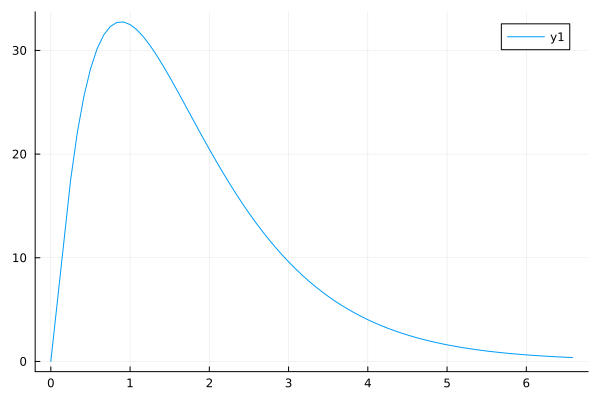

In [251]:
tsC2 = dat["sts"][1:end];
ts = 0:tsC2[end];
ivss = [40000/5, 0, 0, mean(InitsY0[1]), mean(InitsY0[2]), mean(InitsY0[3]), 0, 0, 0, 0, 0, 40000, 0, 40000*(posterO[1,13]*0.12)];;
samps = convert.(Int, tsC2);

SimulsAll, SimulsAll2, SimulsAll3 = PyruvateHP_NMR_SolveAllCp(ts, vcat(trueP, 0), ivss, samps);
plot(tsC2./60, SimulsAll[:,11,1])

In [238]:
SimulsAll2[1]

1×15 Matrix{Float64}:
 -0.0  40000.0  0.0  0.0  450.0  12599.0  …  0.0  0.0  40000.0  0.0  72000.0

In [100]:
ivsss2[1]/2

14028.237654457684

In [253]:
tsC2/30

78-element Vector{Float64}:
  0.0
  0.5
  0.6666666666666666
  0.8333333333333334
  1.0
  1.1666666666666667
  1.3333333333333333
  1.5
  1.6666666666666667
  1.8333333333333333
  ⋮
 11.833333333333334
 12.0
 12.166666666666666
 12.333333333333334
 12.5
 12.666666666666666
 12.833333333333334
 13.0
 13.166666666666666